In [29]:
from functools import partial
from jax import jit, vmap
import jax.numpy as jnp
import jax.random as random
from jpdenet.grad import egrad, gradient_descent
from jpdenet.loss import ic_loss, bc_loss, MSE
from jpdenet.model import init_mlp_params, mlp_forward
from jpdenet.train import create_batches
import matplotlib.pyplot as plt
import numpy as np

PRNGKEY = random.PRNGKey(1)

ndims = 1

In [30]:
params = init_mlp_params(PRNGKEY, (ndims + 1, 20, 20, 1))
batch_mlp_forward = jit(vmap(mlp_forward, in_axes=(None, 0)))

In [31]:
def residual_loss(params, xb):
    """
    1D scalar advection equation
    """
    grads = egrad(batch_mlp_forward)(params, xb)
    dudt = grads[:, 1]
    dudx = grads[:, 0]
    return MSE(dudt + dudx)


def u0(x):
    """
    initial square wave
    """
    return jnp.where(x < 0.25, 0.0, jnp.where(x > 0.75, 0.0, 1.0))


def loss(params, xb):
    """
    lossfcn
    """
    out = residual_loss(params, xb)
    out += ic_loss(u0, batch_mlp_forward, params, xb)
    out += bc_loss(batch_mlp_forward, params, xb)
    return out

In [32]:
n_data = 10000
n_epochs = 200
n_batches = 100
lr = 1e-2
print_every = 10

x_train = random.uniform(PRNGKEY, (n_data, ndims + 1))

In [33]:
loss_vals = []
key = PRNGKEY
for epoch in range(n_epochs):
    key, _ = random.split(key)
    for xb in create_batches(key, x_train, n_batches):
        params, loss_val = gradient_descent(lossfcn=loss, params=params, xb=xb, lr=lr)
        loss_vals.append(loss_val)
    if (epoch + 1) % print_every == 0:
        print(f"epoch {epoch + 1}, loss {loss_vals[-1]}")

epoch 10, loss 0.23857636749744415
epoch 20, loss 0.21390780806541443
epoch 30, loss 0.18926765024662018
epoch 40, loss 0.17526490986347198
epoch 50, loss 0.16203205287456512
epoch 60, loss 0.1540117859840393
epoch 70, loss 0.15850993990898132
epoch 80, loss 0.13800613582134247
epoch 90, loss 0.13362379372119904
epoch 100, loss 0.12427403032779694
epoch 110, loss 0.09572373330593109
epoch 120, loss 0.07504671812057495
epoch 130, loss 0.05528990179300308
epoch 140, loss 0.05844740569591522
epoch 150, loss 0.047936029732227325
epoch 160, loss 0.058851949870586395
epoch 170, loss 0.050425849854946136
epoch 180, loss 0.0507352277636528
epoch 190, loss 0.04863462969660759
epoch 200, loss 0.05334842950105667


Text(0, 0.5, 'loss')

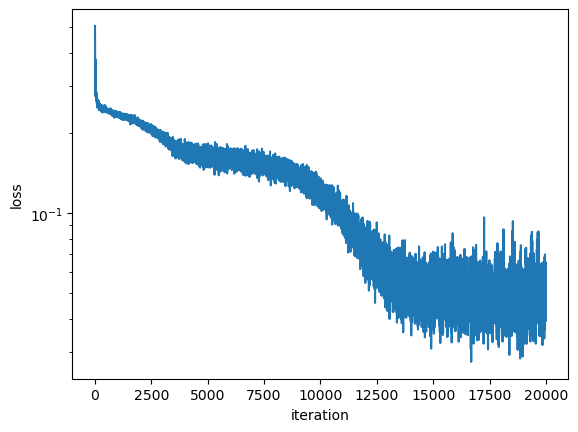

In [34]:
plt.plot(loss_vals)
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("loss")

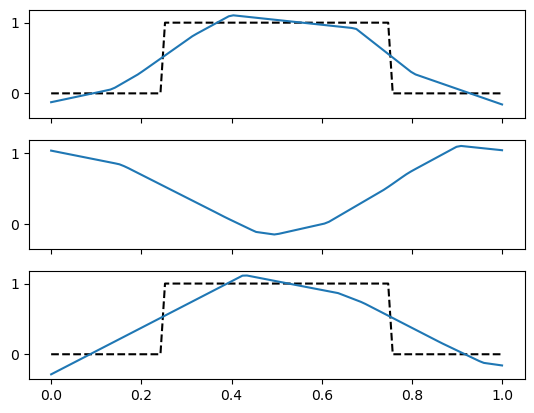

In [35]:
fix, axs = plt.subplots(3, sharex=True, sharey=True)

N = 100

x = np.linspace(0, 1, N)


def model(x, t: float = 0.0, N: int = 100):
    X = np.empty((N, 2))
    X[:, 0] = x
    X[:, 1] = t
    return batch_mlp_forward(params, X)


axs[0].plot(x, u0(x), color="k", linestyle="--")
axs[0].plot(x, model(x, 0))
axs[1].plot(x, model(x, 0.5))
axs[2].plot(x, u0(x), color="k", linestyle="--")
axs[2].plot(x, model(x, 1.0))